# Smart Meter Signal Processing

### In this notebook, we'll apply some signal decomposition techniques on smart meter data readings. The goal is to be able to deconstruct kWh timeseries data into signals for individual devices.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import signal
from pyts.decomposition import SingularSpectrumAnalysis

sns.set(rc={'figure.figsize':(11, 4)})

### Some utilities

In [2]:
def differences(_df, diff_col, out_col):
    '''
    Calculates differences between diff_col in a row and the previous row and outputs the result to out_col in the row.
    Assumes out_col isn't defined.
    '''
    _df[out_col] = 0.0000
    _df.at[0, out_col] = 0.0
    for i, row in _df.iterrows():
        if i != 0:
            _df.at[i, out_col] = row[diff_col] - _df.iloc[i-1][diff_col]
    return _df

### Let's start by looking at the data we're working with.

In [3]:
df1 = pd.read_csv("../data/Metermind_export_-_3558a8b5-0138-4444-848e-abb632c56ff9.csv")
df2 = pd.read_csv("../data/Metermind_export_-_f9aee127-a39b-4f8c-aecb-dffb81d5e3f0.csv")

## Smart Meter Data

In [4]:
del df1["device_type"]

In [5]:
df1.head()

,id,meter,timestamp,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator
0,48012,KA6U001660326812,2020-07-06 11:30:01,12674.378,8388.644,3192.424,7504.061,2
1,48013,KA6U001660326812,2020-07-06 11:45:05,12674.378,8388.644,3192.424,7504.300,2
2,48014,KA6U001660326812,2020-07-06 12:00:08,12674.378,8388.644,3192.424,7504.799,2
3,48015,KA6U001660326812,2020-07-06 12:15:01,12674.378,8388.644,3192.424,7505.058,2
4,48016,KA6U001660326812,2020-07-06 12:30:04,12674.378,8388.649,3192.424,7505.216,2


In [6]:
df1.tail()

,id,meter,timestamp,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator
8774,56786,KA6U001660326812,2020-10-05 21:00:01,12955.178,8529.807,3453.465,8163.954,1
8775,56787,KA6U001660326812,2020-10-05 21:15:05,12955.448,8529.807,3453.465,8163.954,1
8776,56788,KA6U001660326812,2020-10-05 21:30:08,12955.550,8529.807,3453.465,8163.954,1
8777,56789,KA6U001660326812,2020-10-05 21:45:01,12955.644,8529.807,3453.465,8163.954,1
8778,56790,KA6U001660326812,2020-10-05 22:00:05,12955.733,8529.807,3453.465,8163.954,1


<AxesSubplot:xlabel='timestamp'>

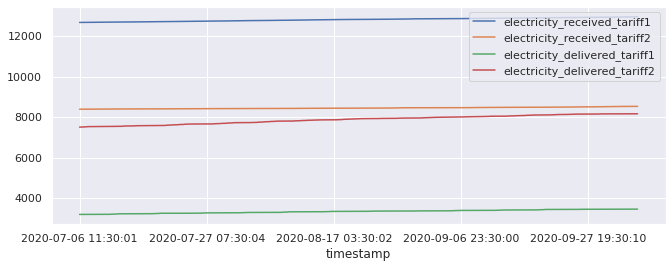

In [7]:
df1 = df1.set_index('timestamp')
num_cols = ['electricity_received_tariff1',
            'electricity_received_tariff2',
            'electricity_delivered_tariff1',
            'electricity_delivered_tariff2']
df1[num_cols] = df1[num_cols].astype(float)
df1[num_cols].plot()

In [8]:
df1 = df1.reset_index()

In [9]:
df1.head()

,timestamp,id,meter,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator
0,2020-07-06 11:30:01,48012,KA6U001660326812,12674.378,8388.644,3192.424,7504.061,2
1,2020-07-06 11:45:05,48013,KA6U001660326812,12674.378,8388.644,3192.424,7504.300,2
2,2020-07-06 12:00:08,48014,KA6U001660326812,12674.378,8388.644,3192.424,7504.799,2
3,2020-07-06 12:15:01,48015,KA6U001660326812,12674.378,8388.644,3192.424,7505.058,2
4,2020-07-06 12:30:04,48016,KA6U001660326812,12674.378,8388.649,3192.424,7505.216,2


In [10]:
high_tariff = 0.4
low_tariff = 0.3

### Calculate kWh based on tarrifs

In [11]:
df1['elec_rcvd_1'] = 0.0
df1['elec_rcvd_2'] = 0.0
df1['elec_dlvd_1'] = 0.0
df1['elec_dlvd_2'] = 0.0
for i, row in df1.iterrows():
    if row['electricity_tariff_indicator'] == 1:
        df1.at[i, 'elec_rcvd_1'] = row['electricity_received_tariff1'] * low_tariff
        df1.at[i, 'elec_rcvd_2'] = row['electricity_received_tariff2'] * low_tariff
        df1.at[i, 'elec_dlvd_1'] = row['electricity_delivered_tariff1'] * low_tariff
        df1.at[i, 'elec_dlvd_2'] = row['electricity_delivered_tariff2'] * low_tariff
    else:
        df1.at[i, 'elec_rcvd_1'] = row['electricity_received_tariff1'] * high_tariff
        df1.at[i, 'elec_rcvd_2'] = row['electricity_received_tariff2'] * high_tariff
        df1.at[i, 'elec_dlvd_1'] = row['electricity_delivered_tariff1'] * high_tariff
        df1.at[i, 'elec_dlvd_2'] = row['electricity_delivered_tariff2'] * high_tariff

In [12]:
df1.head()

,timestamp,id,meter,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator,elec_rcvd_1,elec_rcvd_2,elec_dlvd_1,elec_dlvd_2
0,2020-07-06 11:30:01,48012,KA6U001660326812,12674.378,8388.644,3192.424,7504.061,2,5069.7512,3355.4576,1276.9696,3001.6244
1,2020-07-06 11:45:05,48013,KA6U001660326812,12674.378,8388.644,3192.424,7504.300,2,5069.7512,3355.4576,1276.9696,3001.7200
2,2020-07-06 12:00:08,48014,KA6U001660326812,12674.378,8388.644,3192.424,7504.799,2,5069.7512,3355.4576,1276.9696,3001.9196
3,2020-07-06 12:15:01,48015,KA6U001660326812,12674.378,8388.644,3192.424,7505.058,2,5069.7512,3355.4576,1276.9696,3002.0232
4,2020-07-06 12:30:04,48016,KA6U001660326812,12674.378,8388.649,3192.424,7505.216,2,5069.7512,3355.4596,1276.9696,3002.0864


### Now get differences and plot

In [13]:
df1 = differences(df1, 'elec_rcvd_1', 'elec_rcvd_1_ts')
df1 = differences(df1, 'elec_rcvd_2', 'elec_rcvd_2_ts')
df1 = differences(df1, 'elec_dlvd_1', 'elec_dlvd_1_ts')
df1 = differences(df1, 'elec_dlvd_2', 'elec_dlvd_2_ts')

In [14]:
# df1.head(50)

<AxesSubplot:xlabel='timestamp'>

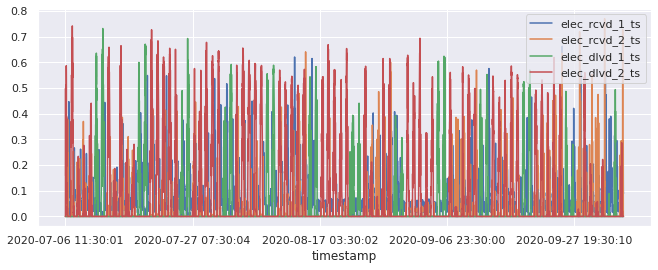

In [19]:
df1 = df1.set_index('timestamp')
num_cols = ['elec_rcvd_1_ts',
            'elec_rcvd_2_ts',
            'elec_dlvd_1_ts',
            'elec_dlvd_2_ts']
df1[num_cols] = df1[num_cols].astype(float)
df1[num_cols].plot()

### That's a bit strange... Let's try raw tariff differences

In [20]:
df1 = df1.reset_index()

In [21]:
df1 = differences(df1, 'electricity_received_tariff1', 'elec_rcvd_1_ts')
df1 = differences(df1, 'electricity_received_tariff2', 'elec_rcvd_2_ts')
df1 = differences(df1, 'electricity_delivered_tariff1', 'elec_dlvd_1_ts')
df1 = differences(df1, 'electricity_delivered_tariff2', 'elec_dlvd_2_ts')

<AxesSubplot:xlabel='timestamp'>

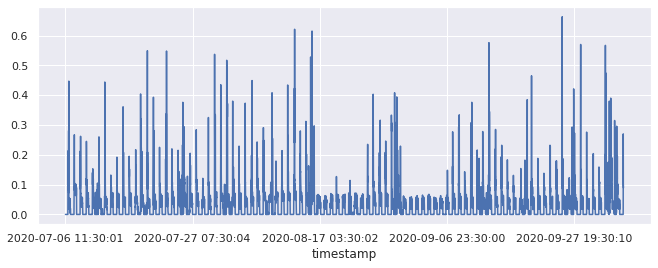

In [22]:
df1 = df1.set_index('timestamp')
num_cols = ['elec_rcvd_1_ts',
            'elec_rcvd_2_ts',
            'elec_dlvd_1_ts',
            'elec_dlvd_2_ts']
df1['elec_rcvd_1_ts'] = df1['elec_rcvd_1_ts'].astype(float)
df1['elec_rcvd_1_ts'].plot()

### That's better, now let's jump into some decomposition.

## Seasonal Decomposition (daily trend)

Doesn't seem too useful

In [23]:
df1 = df1.reset_index()

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 96 
model = 'additive'

decomposition = seasonal_decompose(
    df1.set_index("timestamp").elec_rcvd_1_ts.interpolate("linear"),
    period=decompfreq,
    model=model)

In [25]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

### Meter readings normalized for a day

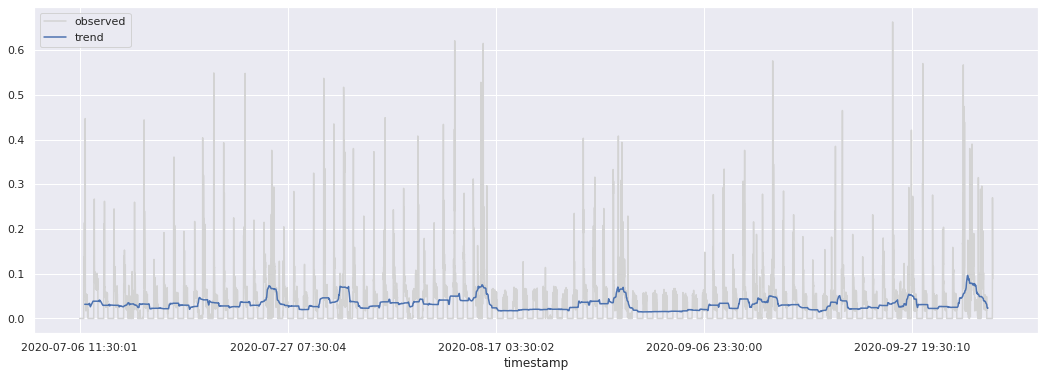

In [26]:
fig, ax = plt.subplots(figsize=(18,6))
df1.plot(x="timestamp", y="elec_rcvd_1_ts", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend")
plt.legend(loc='upper left')

# plt.savefig('images/intro-trend.png');

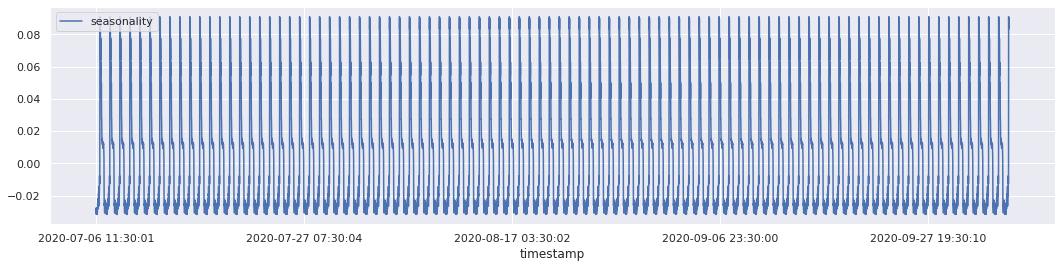

In [27]:
fig, ax = plt.subplots(figsize=(18,4))
seasonal.plot(ax=ax, label="seasonality")
plt.legend(loc='upper left')

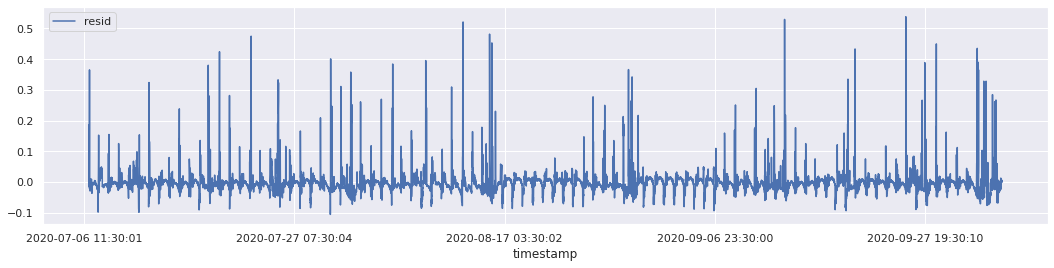

In [28]:
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality")
plt.legend(loc='upper left')

## Periodogram

Fancy Jose stuff. Taken from [Time Series Analysis and Its Applications](https://www.stat.pitt.edu/stoffer/tsa4/tsa4.pdf), Ch 4. A Periodogram calculates the spectral density of a TS at every point.

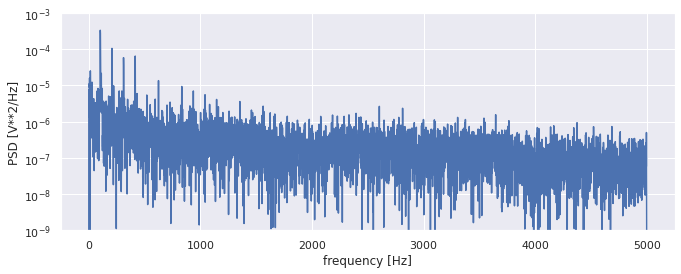

In [29]:
f, Pxx_den = signal.periodogram(df1['elec_rcvd_1_ts'].to_numpy(), 10e3)

plt.semilogy(f, Pxx_den)
plt.ylim([1e-9, 1e-3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()


## Singular Spectrum Analysis

#### This is the most important one. SSA is used to split a signal into its constituent parts. In our case, we are using this to represent devices that exist in the household. Each decomposition could represent a unique device that has a periodic usage pattern.

In [30]:
elec_rcvd = [df1['elec_rcvd_1_ts'].to_list(), df1['elec_rcvd_2_ts'].to_list()]
elec_rcvd_np = np.array(elec_rcvd)
# elec_rcvd_np = df1['elec_rcvd_1_ts'].to_numpy().reshape(1,-1)

In [31]:
# We decompose the time series into three subseries
window_size = 20
groups = [np.arange(i, i + 5) for i in range(0, 11, 5)]

# Singular Spectrum Analysis
ssa = SingularSpectrumAnalysis(window_size=15, groups=groups)
X_ssa = ssa.fit_transform(elec_rcvd_np)

In [32]:
X_ssa[1]

array([[-4.80920302e-04, -4.30806021e-05,  7.28497584e-04, ...,
         2.23585160e-02, -4.73990239e-02, -6.25260876e-02],
       [ 8.48816790e-04, -1.29279948e-05, -1.42329106e-03, ...,
        -3.59722683e-02,  2.18189296e-02,  9.34374546e-02],
       [-3.67896488e-04,  5.60085969e-05,  6.94793477e-04, ...,
         1.36137522e-02,  2.55800943e-02, -3.09113669e-02]])

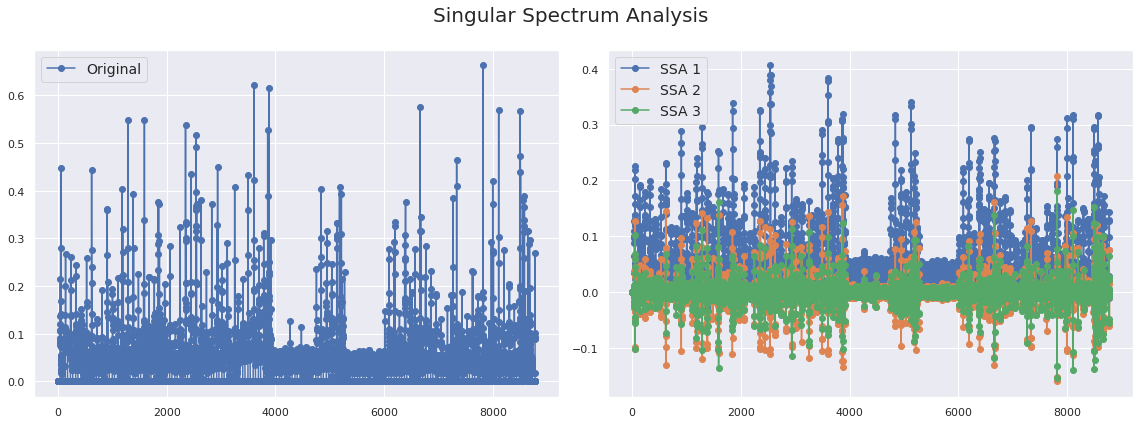

In [33]:
# Show the results for the first time series and its subseries
plt.figure(figsize=(16, 6))

ax1 = plt.subplot(121)
ax1.plot(elec_rcvd_np[0], 'o-', label='Original')
ax1.legend(loc='best', fontsize=14)

ax2 = plt.subplot(122)
for i in range(len(groups)):
    ax2.plot(X_ssa[0, i], 'o-', label='SSA {0}'.format(i + 1))
ax2.legend(loc='best', fontsize=14)

plt.suptitle('Singular Spectrum Analysis', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## SSA on daily data

#### Let's get a little more specific. We can split our DF roughly so that they represent readings on a daily basis. We can rerun SSA on this information.

In [34]:
pd.set_option('display.max_rows', 1000)

In [36]:
df1.drop(i for i in range(50)).reset_index(drop=True)

,timestamp,id,meter,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator,elec_rcvd_1,elec_rcvd_2,elec_dlvd_1,elec_dlvd_2,elec_rcvd_1_ts,elec_rcvd_2_ts,elec_dlvd_1_ts,elec_dlvd_2_ts
0,2020-07-07 00:00:05,48062,KA6U001660326812,12675.900,8390.081,3192.424,7511.831,1,3802.7700,2517.0243,957.7272,2253.5493,0.281,0.000,0.0,0.0
1,2020-07-07 00:15:08,48063,KA6U001660326812,12675.972,8390.081,3192.424,7511.831,1,3802.7916,2517.0243,957.7272,2253.5493,0.072,0.000,0.0,0.0
2,2020-07-07 00:30:01,48064,KA6U001660326812,12676.140,8390.081,3192.424,7511.831,1,3802.8420,2517.0243,957.7272,2253.5493,0.168,0.000,0.0,0.0
3,2020-07-07 00:45:04,48065,KA6U001660326812,12676.587,8390.081,3192.424,7511.831,1,3802.9761,2517.0243,957.7272,2253.5493,0.447,0.000,0.0,0.0
4,2020-07-07 01:00:08,48066,KA6U001660326812,12676.634,8390.081,3192.424,7511.831,1,3802.9902,2517.0243,957.7272,2253.5493,0.047,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8724,2020-10-05 21:00:01,56786,KA6U001660326812,12955.178,8529.807,3453.465,8163.954,1,3886.5534,2558.9421,1036.0395,2449.1862,0.018,0.269,0.0,0.0
8725,2020-10-05 21:15:05,56787,KA6U001660326812,12955.448,8529.807,3453.465,8163.954,1,3886.6344,2558.9421,1036.0395,2449.1862,0.270,0.000,0.0,0.0
8726,2020-10-05 21:30:08,56788,KA6U001660326812,12955.550,8529.807,3453.465,8163.954,1,3886.6650,2558.9421,1036.0395,2449.1862,0.102,0.000,0.0,0.0
8727,2020-10-05 21:45:01,56789,KA6U001660326812,12955.644,8529.807,3453.465,8163.954,1,3886.6932,2558.9421,1036.0395,2449.1862,0.094,0.000,0.0,0.0


## Gas Meter Data (not used)

In [30]:
df2.shape

(4392, 6)

In [31]:
df2 = df2.drop([i for i in range(0,df2.shape[0], 2)]).reset_index(drop=True)

In [32]:
df2.head()

,id,mbusdevice,meter,timestamp,reading,device_type
0,11998,2.810154e+16,KA6U001660326812,2020-07-06 12:00:00,12683.872,3
1,11999,2.810154e+16,KA6U001660326812,2020-07-06 13:00:00,12683.879,3
2,12000,2.810154e+16,KA6U001660326812,2020-07-06 14:00:00,12683.884,3
3,12001,2.810154e+16,KA6U001660326812,2020-07-06 15:00:00,12683.893,3
4,12002,2.810154e+16,KA6U001660326812,2020-07-06 16:00:00,12683.896,3


<AxesSubplot:xlabel='timestamp'>

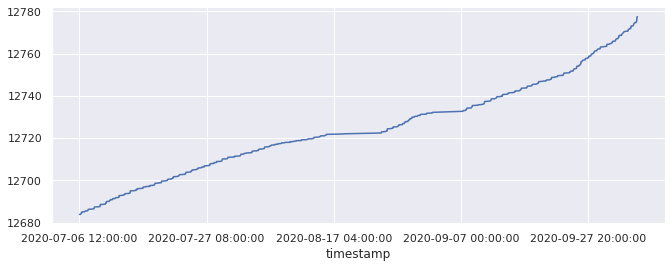

In [33]:
df2 = df2.set_index('timestamp')
df2['reading'] = df2['reading'].astype(float)
df2['reading'].plot()

In [34]:
df2 = differences(df2.reset_index(), 'reading', 'usage')

In [35]:
df2.head()

,timestamp,id,mbusdevice,meter,reading,device_type,usage
0,2020-07-06 12:00:00,11998,2.810154e+16,KA6U001660326812,12683.872,3,0.000
1,2020-07-06 13:00:00,11999,2.810154e+16,KA6U001660326812,12683.879,3,0.007
2,2020-07-06 14:00:00,12000,2.810154e+16,KA6U001660326812,12683.884,3,0.005
3,2020-07-06 15:00:00,12001,2.810154e+16,KA6U001660326812,12683.893,3,0.009
4,2020-07-06 16:00:00,12002,2.810154e+16,KA6U001660326812,12683.896,3,0.003


<AxesSubplot:xlabel='timestamp'>

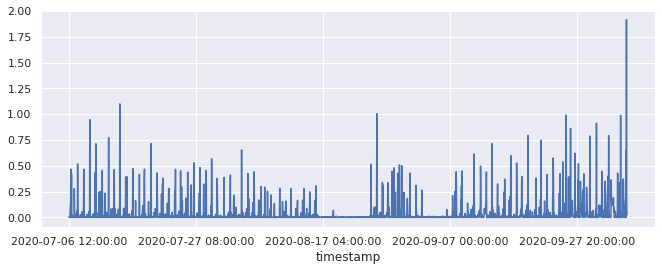

In [36]:
df2 = df2.set_index('timestamp')
# df2['reading'] = df2['usage'].astype(float)
df2['usage'].plot()